In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display, Markdown
from collections import Counter
import random
from lightgbm import LGBMClassifier

In [2]:
EXP_NAME_CONTEXT = 'window_step_1__on_context__all__agg_weighted_llama2'

In [3]:
os.getcwd()

'c:\\Users\\Piotr.Matys\\Python_Projects\\hallu_project\\Research\\notebooks'

In [4]:
context_df = None

for f_ in os.listdir(os.path.join("..", "..", EXP_NAME_CONTEXT)):
        
    if f_.startswith('attension'):

        if context_df is None:
            context_df = pd.read_parquet(os.path.join("..", "..", EXP_NAME_CONTEXT, f_))
        else:
            context_df = pd.concat((context_df, pd.read_parquet(os.path.join("..", "..", EXP_NAME_CONTEXT, f_))))

context_df = context_df.dropna()

In [5]:
context_df['label'].value_counts()

label
0    361037
1     87986
Name: count, dtype: int64

In [6]:
N_LAYERS = 32
N_HEADS = 32

In [7]:

context_df.columns = [
    f'layer_{i}_head_{j}' for i in range(N_LAYERS) for j in range(N_HEADS)
] + [
    'context_perc', 'label', 'dataset', 'example_name'
]

In [8]:
context_df['dataset'].value_counts()

dataset
poquad_v2      108016
nq             102109
xsum            58931
cnndm           57922
hotpotqa_en     43150
polqa           42223
hotpotqa_pl     36672
Name: count, dtype: int64

In [9]:
context_df

layer_0_head_0  layer_0_head_1  layer_0_head_2  layer_0_head_3  \
0            0.828125        0.912598        0.917480        0.583008   
1            0.859375        0.914551        0.915527        0.573242   
2            0.856934        0.907227        0.910645        0.522461   
3            0.850586        0.902832        0.910645        0.517090   
4            0.849609        0.900391        0.910156        0.514648   
...               ...             ...             ...             ...   
41115        0.545898        0.603516        0.624023        0.186035   
41116        0.507812        0.581543        0.623047        0.184570   
41117        0.506836        0.579102        0.620117        0.179810   
41118        0.588379        0.705078        0.708496        0.402344   
41119        0.594238        0.701172        0.708496        0.399902   

       layer_0_head_4  layer_0_head_5  layer_0_head_6  layer_0_head_7  \
0            0.876953        0.916992        0.899902        0.934082   
1            0.875000        0.919434        0.891113        0.933105   
2            0.860840        0.913574        0.883301        0.925781   
3            0.858398        0.911621        0.892578        0.925781   
4            0.855957        0.912109        0.892090        0.925293   
...               ...             ...             ...             ...   
41115        0.468506        0.618164        0.576660        0.704590   
41116        0.468018        0.607910        0.570801        0.701660   
41117        0.463135        0.607422        0.568848        0.698730   
41118        0.660645        0.672852        0.708496        0.785156   
41119        0.658203        0.673340        0.714844        0.784180   

       layer_0_head_8  layer_0_head_9  ...  layer_31_head_26  \
0            0.845215        0.932129  ...          0.203979   
1            0.879883        0.931641  ...          0.207520   
2            0.873047        0.918457  ...          0.125000   
3            0.865723        0.916992  ...          0.151733   
4            0.862793        0.917480  ...          0.165527   
...               ...             ...  ...               ...   
41115        0.599609        0.585449  ...          0.142212   
41116        0.527344        0.583008  ...          0.116760   
41117        0.537109        0.576660  ...          0.095337   
41118        0.612793        0.707031  ...          0.185547   
41119        0.615234        0.703125  ...          0.178101   

       layer_31_head_27  layer_31_head_28  layer_31_head_29  layer_31_head_30  \
0              0.064697          0.458740          0.119629          0.216431   
1              0.072449          0.449463          0.119263          0.237061   
2              0.082214          0.405518          0.155884          0.310059   
3              0.073364          0.393799          0.167114          0.329590   
4              0.058197          0.433105          0.183594          0.410156   
...                 ...               ...               ...               ...   
41115          0.015961          0.238770          0.106201          0.208984   
41116          0.015976          0.232056          0.099670          0.168823   
41117          0.016205          0.241943          0.090332          0.137451   
41118          0.044769          0.304199          0.111206          0.204102   
41119          0.049011          0.292969          0.107666          0.185425   

       layer_31_head_31  context_perc  label  dataset  \
0              0.035675        0.9217      0       nq   
1              0.039856        0.9212      0       nq   
2              0.045807        0.9168      0       nq   
3              0.043457        0.9163      0       nq   
4              0.052216        0.9158      0       nq   
...                 ...           ...    ...      ...   
41115          0.050476        0.6358      0     xsum   
41116          0.042816        0.6348      0     xsum  

In [10]:
context_df['context_perc_scaler'] = 1 / context_df['context_perc'] ** (1 / 2)

In [11]:
context_df[[col for col in context_df.columns if 'layer' in col]] = context_df[[col for col in context_df.columns if 'layer' in col]].multiply(context_df['context_perc_scaler'], axis=0)

In [ ]:
context_df

layer_0_head_0  layer_0_head_1  layer_0_head_2  layer_0_head_3  \
0            0.862583        0.950571        0.955657        0.607267   
1            0.895377        0.952864        0.953881        0.597257   
2            0.894973        0.947498        0.951068        0.545653   
3            0.888586        0.943166        0.951327        0.540191   
4            0.887808        0.940872        0.951077        0.537787   
...               ...             ...             ...             ...   
41115        0.684623        0.756882        0.782601        0.233311   
41116        0.637360        0.729900        0.781992        0.231656   
41117        0.636636        0.727409        0.778929        0.225859   
41118        0.696807        0.835012        0.839059        0.476489   
41119        0.704339        0.831085        0.839766        0.473996   

       layer_0_head_4  layer_0_head_5  layer_0_head_6  layer_0_head_7  \
0            0.913443        0.955148        0.937347        0.972949   
1            0.911656        0.957951        0.928445        0.972196   
2            0.899053        0.954128        0.922510        0.966877   
3            0.896747        0.952348        0.932454        0.967140   
4            0.894441        0.953118        0.932198        0.966894   
...               ...             ...             ...             ...   
41115        0.587563        0.775253        0.723202        0.883642   
41116        0.587413        0.762994        0.716417        0.880660   
41117        0.581743        0.762982        0.714529        0.877675   
41118        0.782390        0.796846        0.839059        0.929847   
41119        0.780155        0.798096        0.847290        0.929473   

       layer_0_head_8  layer_0_head_9  ...  layer_31_head_27  \
0            0.880384        0.970915  ...          0.067389   
1            0.916744        0.970670  ...          0.075484   
2            0.911801        0.959227  ...          0.085864   
3            0.904399        0.957959  ...          0.076642   
4            0.901584        0.958730  ...          0.060814   
...               ...             ...  ...               ...   
41115        0.751983        0.734225  ...          0.020017   
41116        0.661874        0.731739  ...          0.020052   
41117        0.674663        0.724342  ...          0.020355   
41118        0.725720        0.837325  ...          0.053019   
41119        0.729225        0.833400  ...          0.058092   

       layer_31_head_28  layer_31_head_29  layer_31_head_30  layer_31_head_31  \
0              0.477828          0.124607          0.225436          0.037159   
1              0.468292          0.124259          0.246992          0.041526   
2              0.423518          0.162803          0.323822          0.047840   
3              0.411392          0.174580          0.344314          0.045398   
4              0.452578          0.191848          0.428597          0.054563   
...                 ...               ...               ...               ...   
41115          0.299446          0.133189          0.262092          0.063303   
41116          0.291255          0.125097          0.211892          0.053739   
41117          0.303905          0.113466          0.172652          0.039675   
41118          0.360258          0.131699          0.241714          0.087101   
41119          0.347250          0.127614          0.219780          0.080157   

       context_perc  label  dataset                 example_name  \
0            0.9217      0       nq             nq_0.npy__(0, 8)   
1            0.9212      0       nq             nq_0.npy__(1, 9)   
2            0.9168      0       nq           nq_0.npy__(10, 18)   
3            0.9163      0       nq           nq_0.npy__(11, 19)   
4            0.9158      0       nq           nq_0.npy__(12, 20)   
...             ...    ...      ...                          ...   
41115        0.6358      0     xsum

: 

In [13]:
context_df = context_df.drop(columns=['context_perc', 'context_perc_scaler'])

In [14]:
context_df

layer_0_head_0  layer_0_head_1  layer_0_head_2  layer_0_head_3  \
0            0.862583        0.950571        0.955657        0.607267   
1            0.895377        0.952864        0.953881        0.597257   
2            0.894973        0.947498        0.951068        0.545653   
3            0.888586        0.943166        0.951327        0.540191   
4            0.887808        0.940872        0.951077        0.537787   
...               ...             ...             ...             ...   
41115        0.684623        0.756882        0.782601        0.233311   
41116        0.637360        0.729900        0.781992        0.231656   
41117        0.636636        0.727409        0.778929        0.225859   
41118        0.696807        0.835012        0.839059        0.476489   
41119        0.704339        0.831085        0.839766        0.473996   

       layer_0_head_4  layer_0_head_5  layer_0_head_6  layer_0_head_7  \
0            0.913443        0.955148        0.937347        0.972949   
1            0.911656        0.957951        0.928445        0.972196   
2            0.899053        0.954128        0.922510        0.966877   
3            0.896747        0.952348        0.932454        0.967140   
4            0.894441        0.953118        0.932198        0.966894   
...               ...             ...             ...             ...   
41115        0.587563        0.775253        0.723202        0.883642   
41116        0.587413        0.762994        0.716417        0.880660   
41117        0.581743        0.762982        0.714529        0.877675   
41118        0.782390        0.796846        0.839059        0.929847   
41119        0.780155        0.798096        0.847290        0.929473   

       layer_0_head_8  layer_0_head_9  ...  layer_31_head_25  \
0            0.880384        0.970915  ...          0.220478   
1            0.916744        0.970670  ...          0.231602   
2            0.911801        0.959227  ...          0.212779   
3            0.904399        0.957959  ...          0.181849   
4            0.901584        0.958730  ...          0.228968   
...               ...             ...  ...               ...   
41115        0.751983        0.734225  ...          0.201621   
41116        0.661874        0.731739  ...          0.182015   
41117        0.674663        0.724342  ...          0.139992   
41118        0.725720        0.837325  ...          0.293179   
41119        0.729225        0.833400  ...          0.279102   

       layer_31_head_26  layer_31_head_27  layer_31_head_28  layer_31_head_29  \
0              0.212467          0.067389          0.477828          0.124607   
1              0.216213          0.075484          0.468292          0.124259   
2              0.130549          0.085864          0.423518          0.162803   
3              0.158512          0.076642          0.411392          0.174580   
4              0.172969          0.060814          0.452578          0.191848   
...                 ...               ...               ...               ...   
41115          0.178351          0.020017          0.299446          0.133189   
41116          0.146547          0.020052          0.291255          0.125097   
41117          0.119753          0.020355          0.303905          0.113466   
41118          0.219740          0.053019          0.360258          0.131699   
41119          0.211099          0.058092          0.347250          0.127614   

       layer_31_head_30  layer_31_head_31  label  dataset  \
0              0.225436          0.037159      0       nq   
1              0.246992          0.041526      0       nq   
2              0.323822          0.047840      0       nq   
3              0.344314          0.045398      0       nq   
4              0.428597          0.054563      0       nq   
...                 ...               ...    ...      ...   
41115          0.262092          0.063303      0     xsum   
41116          0.211892

### What is the difference between attension for hallucinated and correct answers

In [14]:
stats_grouped = context_df.drop(columns=['dataset']).groupby('label').agg(['median']).T
stats_grouped['median_proportion'] = stats_grouped[0] / stats_grouped[1]
stats_grouped

label                           0         1  median_proportion
layer_0_head_0   median  0.734731  0.725271           1.013043
layer_0_head_1   median  0.843794  0.828024           1.019045
layer_0_head_2   median  0.875331  0.865118           1.011806
layer_0_head_3   median  0.382555  0.316616           1.208260
layer_0_head_4   median  0.767401  0.729583           1.051834
...                           ...       ...                ...
layer_31_head_27 median  0.045676  0.044709           1.021638
layer_31_head_28 median  0.353327  0.324464           1.088954
layer_31_head_29 median  0.120929  0.122310           0.988705
layer_31_head_30 median  0.195648  0.182684           1.070967
layer_31_head_31 median  0.034586  0.031376           1.102294

[1024 rows x 3 columns]

### Differences in median

In [15]:
stats_grouped.sort_values('median_proportion', ascending=False).head(10)

label                           0         1  median_proportion
layer_10_head_14 median  0.236782  0.141264           1.676165
layer_8_head_26  median  0.341981  0.221059           1.547014
layer_12_head_11 median  0.183976  0.119711           1.536831
layer_15_head_14 median  0.487361  0.318827           1.528606
layer_13_head_18 median  0.123544  0.081032           1.524637
layer_11_head_15 median  0.522077  0.342614           1.523807
layer_14_head_7  median  0.536643  0.353481           1.518164
layer_11_head_30 median  0.317718  0.209343           1.517687
layer_11_head_2  median  0.187234  0.125689           1.489666
layer_12_head_16 median  0.539709  0.368226           1.465699

In [16]:
stats_grouped.sort_values('median_proportion', ascending=True).head(10)

label                           0         1  median_proportion
layer_26_head_10 median  0.017262  0.019706           0.875971
layer_9_head_1   median  0.047280  0.053020           0.891746
layer_13_head_25 median  0.061704  0.069186           0.891857
layer_11_head_23 median  0.055246  0.061613           0.896658
layer_22_head_15 median  0.023362  0.025686           0.909531
layer_16_head_26 median  0.064701  0.070562           0.916941
layer_31_head_4  median  0.040362  0.043501           0.927846
layer_11_head_18 median  0.067706  0.072819           0.929785
layer_11_head_0  median  0.011077  0.011778           0.940476
layer_22_head_3  median  0.125491  0.132765           0.945205

In [17]:
stats_grouped_sorted = stats_grouped.sort_values('median_proportion', ascending=False).reset_index()
stats_grouped_sorted

label           level_0 level_1         0         1  median_proportion
0      layer_10_head_14  median  0.236782  0.141264           1.676165
1       layer_8_head_26  median  0.341981  0.221059           1.547014
2      layer_12_head_11  median  0.183976  0.119711           1.536831
3      layer_15_head_14  median  0.487361  0.318827           1.528606
4      layer_13_head_18  median  0.123544  0.081032           1.524637
...                 ...     ...       ...       ...                ...
1019   layer_22_head_15  median  0.023362  0.025686           0.909531
1020   layer_11_head_23  median  0.055246  0.061613           0.896658
1021   layer_13_head_25  median  0.061704  0.069186           0.891857
1022     layer_9_head_1  median  0.047280  0.053020           0.891746
1023   layer_26_head_10  median  0.017262  0.019706           0.875971

[1024 rows x 5 columns]

In [19]:
TOP_N = 10

top_7_props = stats_grouped_sorted.head(TOP_N)['level_0'].to_list()
lowest_7_props = stats_grouped_sorted.tail(TOP_N)['level_0'].to_list()

for_eda = context_df[top_7_props + lowest_7_props + ['label', 'dataset']]

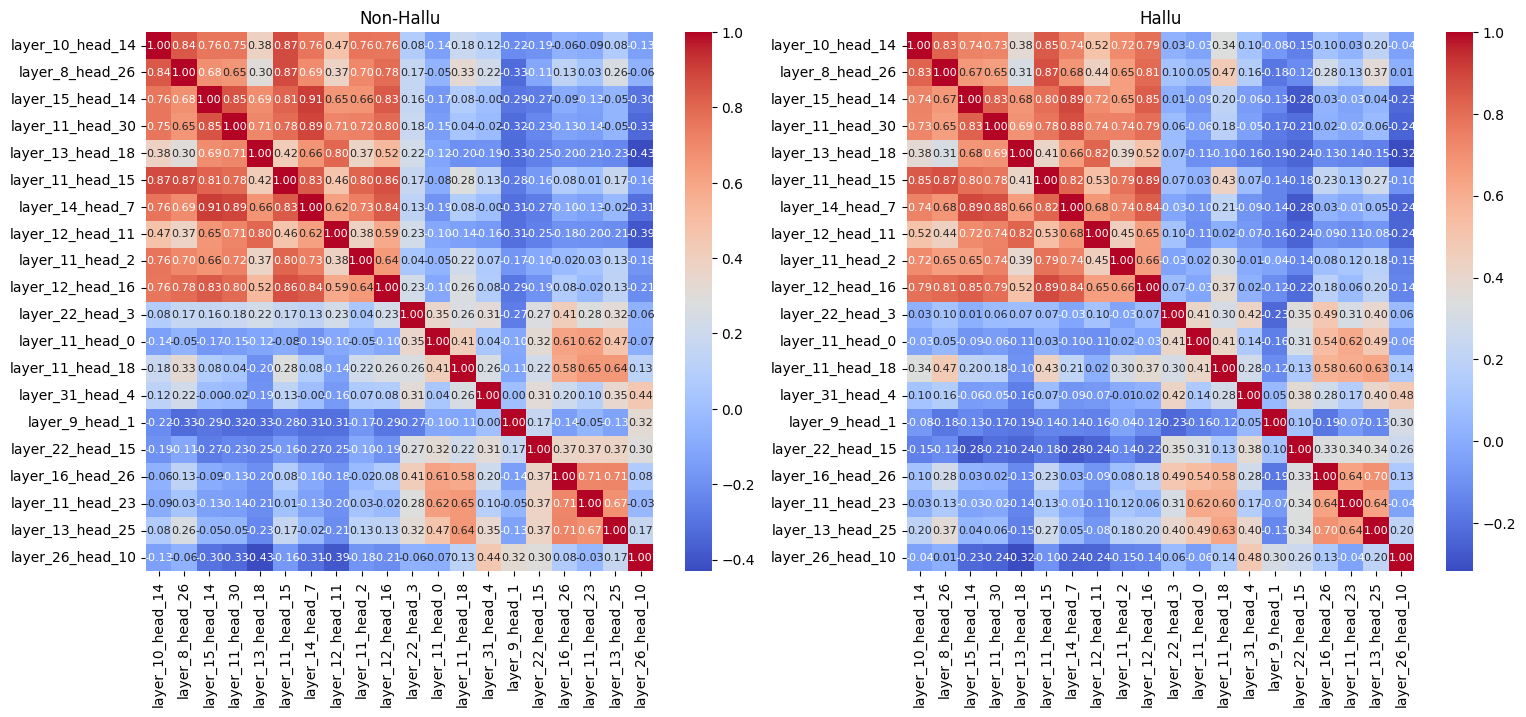

In [20]:
corr_non_hallu = for_eda.loc[for_eda['label'] == 0].drop(columns=['dataset', 'label']).corr()
corr_hallu = for_eda.loc[for_eda['label'] == 1].drop(columns=['dataset', 'label']).corr()
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

for i, (corr, title) in enumerate(zip([corr_non_hallu, corr_hallu], ['Non-Hallu', 'Hallu'])):
    mask = corr.abs() < 0.0
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, ax=ax[i], annot_kws={"size": 8})
    ax[i].set_title(title)

plt.grid(False)
plt.show()

### `Spearman` correletion (looks for monotonic correletions, more robust, no need for liner dependence)

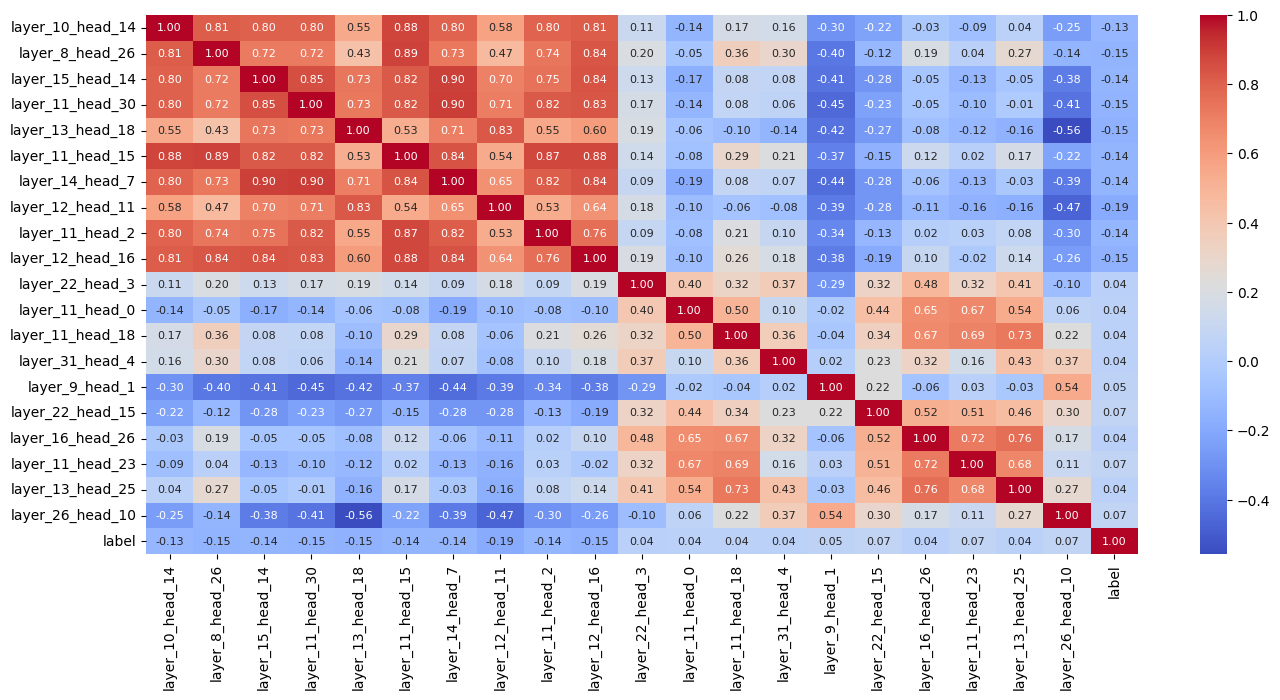

In [21]:
corr_all = for_eda.drop(columns=['dataset']).corr(method='spearman')
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
sns.heatmap(corr_all, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 8}, ax=ax)
plt.grid(False)
plt.show()

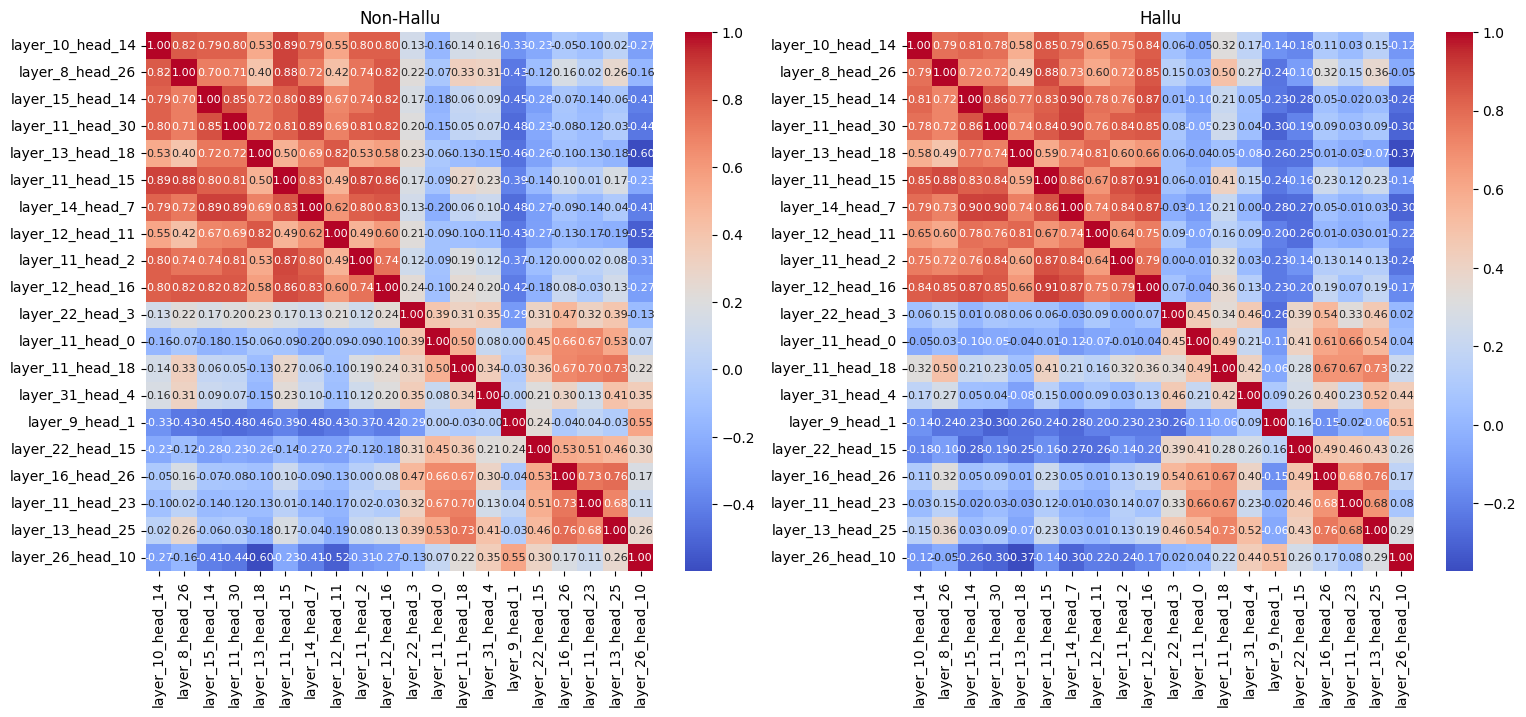

In [22]:
corr_non_hallu = for_eda.loc[for_eda['label'] == 0].drop(columns=['dataset', 'label']).corr(method='spearman')
corr_hallu = for_eda.loc[for_eda['label'] == 1].drop(columns=['dataset', 'label']).corr(method='spearman')
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

for i, (corr, title) in enumerate(zip([corr_non_hallu, corr_hallu], ['Non-Hallu', 'Hallu'])):
    mask = corr.abs() < 0.0
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, ax=ax[i], annot_kws={"size": 8})
    ax[i].set_title(title)

plt.grid(False)
plt.show()

### Before plotting the distributions, I will check also stats for grouped datasets

In [23]:
grouped_df = context_df.groupby(['dataset', 'label']).agg(['median']).T
grouped_df

dataset                     cnndm           hotpotqa_en           hotpotqa_pl  \
label                           0         1           0         1           0   
layer_0_head_0   median  0.722656  0.685059    0.750488  0.766113    0.610840   
layer_0_head_1   median  0.808105  0.771484    0.859375  0.855469    0.723633   
layer_0_head_2   median  0.826660  0.788086    0.878906  0.874512    0.759277   
layer_0_head_3   median  0.382080  0.334229    0.394775  0.349609    0.276611   
layer_0_head_4   median  0.727539  0.688477    0.781250  0.760742    0.645020   
...                           ...       ...         ...       ...         ...   
layer_31_head_28 median  0.271484  0.227295    0.347412  0.300537    0.383789   
layer_31_head_29 median  0.090210  0.088318    0.149170  0.146484    0.126343   
layer_31_head_30 median  0.160645  0.142944    0.244141  0.212158    0.172119   
layer_31_head_31 median  0.030838  0.026855    0.039856  0.034851    0.030579   
context_perc     median  0.834000  0.796500    0.892100  0.889700    0.793500   

dataset                                  nq               polqa            \
label                           1         0         1         0         1   
layer_0_head_0   median  0.626465  0.754395  0.743164  0.643555  0.636230   
layer_0_head_1   median  0.714355  0.864746  0.848145  0.759277  0.742188   
layer_0_head_2   median  0.749023  0.885742  0.873047  0.790039  0.780273   
layer_0_head_3   median  0.240967  0.400635  0.337402  0.326416  0.268066   
layer_0_head_4   median  0.618652  0.788086  0.749512  0.687988  0.653320   
...                           ...       ...       ...       ...       ...   
layer_31_head_28 median  0.353882  0.303467  0.262207  0.340332  0.309326   
layer_31_head_29 median  0.125488  0.127197  0.124390  0.102692  0.101624   
layer_31_head_30 median  0.158447  0.246948  0.224976  0.125122  0.124756   
layer_31_head_31 median  0.027588  0.037079  0.034424  0.024124  0.023499   
context_perc     median  0.783500  0.900300  0.891300  0.822700  0.815100   

dataset                 poquad_v2                xsum            
label                           0         1         0         1  
layer_0_head_0   median  0.473877  0.470947  0.592285  0.604980  
layer_0_head_1   median  0.545898  0.536621  0.673828  0.688477  
layer_0_head_2   median  0.567871  0.564453  0.687988  0.705566  
layer_0_head_3   median  0.252686  0.192627  0.321777  0.310791  
layer_0_head_4   median  0.533691  0.491943  0.619629  0.623047  
...                           ...       ...       ...       ...  
layer_31_head_28 median  0.308838  0.273926  0.283691  0.284668  
layer_31_head_29 median  0.078125  0.073975  0.096497  0.094543  
layer_31_head_30 median  0.110107  0.095154  0.156006  0.150635  
layer_31_head_31 median  0.021317  0.019440  0.032623  0.029388  
context_perc     median  0.607300  0.603400  0.696900  0.713600  

[1025 rows x 14 columns]

In [24]:
dataset_counts = context_df.groupby(['dataset', 'label']).size().to_frame().reset_index().rename(columns={0: 'count'})
dataset_counts

dataset  label  count
0         cnndm      0  52007
1         cnndm      1   5915
2   hotpotqa_en      0  33957
3   hotpotqa_en      1   9193
4   hotpotqa_pl      0  27444
5   hotpotqa_pl      1   9228
6            nq      0  80680
7            nq      1  21429
8         polqa      0  32206
9         polqa      1  10017
10    poquad_v2      0  84055
11    poquad_v2      1  23961
12         xsum      0  50688
13         xsum      1   8243

In [25]:
TOP_N = 10

In [26]:
previous_features = []
highest_non_hallu, highest_hallu = [], []

for dataset in grouped_df.columns.levels[0]:

    stats_grouped = grouped_df[dataset].reset_index()

    stats_grouped = stats_grouped.rename(columns={'level_0': 'feature', 'level_1': 'statistic'})

    stats_grouped['median_diff'] = stats_grouped[0] - stats_grouped[1]
    stats_grouped['median_perc_diff'] = stats_grouped['median_diff'] / stats_grouped[0] * 100
    
    stats_grouped.drop(columns=['median_diff', 'statistic'], inplace=True)

    stats_grouped['median_proportion'] = stats_grouped[0] / stats_grouped[1]

    n_ok, n_hallu = dataset_counts.loc[dataset_counts['dataset'] == dataset, 'count'].values

    # display(Markdown(f"### **{dataset}**, hallu: {n_hallu}, non-hallu: {n_ok}"))

    highest_non_hallu_context = stats_grouped.sort_values('median_proportion', ascending=False).head(TOP_N)
    highest_hallu_context = stats_grouped.sort_values('median_proportion', ascending=True).head(TOP_N)

    previous_features.extend(highest_non_hallu_context['feature'].values)
    previous_features.extend(highest_hallu_context['feature'].values)

    highest_hallu.append(highest_hallu_context)
    highest_non_hallu.append(highest_non_hallu_context)

In [27]:
feature_counts = Counter(previous_features)
common_features = {feature for feature, count in feature_counts.items() if count > 1}

# Generate a random color for each common feature
def generate_random_color():
    return f'#{random.randint(0, 0xFFFFFF):06x}'

# Assign colors from the palette to common features
color_map = {feature: generate_random_color() for feature in common_features}

def highlight_common_features(s):
    return [f'color: {color_map[v]}' if v in color_map else '' for v in s]

In [30]:

display(Markdown(f"## **Highest non-hallu**"))
for df, dataset in zip(highest_non_hallu, grouped_df.columns.levels[0]):

    n_ok, n_hallu = dataset_counts.loc[dataset_counts['dataset'] == dataset, 'count'].values
    display(Markdown(f"### **{dataset}**, hallu: {n_hallu}, non-hallu: {n_ok}"))
    
    styled_df = df.style.apply(highlight_common_features, subset=['feature'])
    display(styled_df)

display(Markdown(f"## **Highest hallu**"))
for df, dataset in zip(highest_hallu, grouped_df.columns.levels[0]):

    n_ok, n_hallu = dataset_counts.loc[dataset_counts['dataset'] == dataset, 'count'].values
    display(Markdown(f"### **{dataset}**, hallu: {n_hallu}, non-hallu: {n_ok}"))

    styled_df = df.style.apply(highlight_common_features, subset=['feature'])
    display(styled_df)



## **Highest non-hallu**

### **cnndm**, hallu: 5915, non-hallu: 52007

### **hotpotqa_en**, hallu: 9193, non-hallu: 33957

### **hotpotqa_pl**, hallu: 9228, non-hallu: 27444

### **nq**, hallu: 21429, non-hallu: 80680

### **polqa**, hallu: 10017, non-hallu: 32206

### **poquad_v2**, hallu: 23961, non-hallu: 84055

### **xsum**, hallu: 8243, non-hallu: 50688

## **Highest hallu**

### **cnndm**, hallu: 5915, non-hallu: 52007

### **hotpotqa_en**, hallu: 9193, non-hallu: 33957

### **hotpotqa_pl**, hallu: 9228, non-hallu: 27444

### **nq**, hallu: 21429, non-hallu: 80680

### **polqa**, hallu: 10017, non-hallu: 32206

### **poquad_v2**, hallu: 23961, non-hallu: 84055

### **xsum**, hallu: 8243, non-hallu: 50688

In [ ]:
context_df[list(common_features) + ['label', 'dataset']]

layer_36_head_9  layer_25_head_13  layer_14_head_13  layer_10_head_6  \
0             0.000003          0.000246          0.000148         0.000127   
1             0.000005          0.000509          0.000129         0.000082   
2             0.000002          0.000496          0.000276         0.000111   
3             0.000004          0.000553          0.000239         0.000108   
4             0.000075          0.000321          0.000266         0.000077   
...                ...               ...               ...              ...   
21275         0.000040          0.000152          0.000015         0.000755   
21276         0.000154          0.000952          0.000224         0.000891   
21277         0.000010          0.000845          0.000280         0.000344   
21278         0.000018          0.001019          0.000545         0.000301   
21279         0.000048          0.000604          0.000545         0.000348   

       layer_23_head_5  layer_4_head_4  layer_11_head_9  layer_31_head_7  \
0             0.000068        0.000216         0.000088         0.000214   
1             0.000017        0.000085         0.000231         0.000360   
2             0.000043        0.000126         0.000151         0.000305   
3             0.000021        0.000099         0.000203         0.000316   
4             0.000085        0.000086         0.000147         0.000227   
...                ...             ...              ...              ...   
21275         0.000220        0.000645         0.000010         0.000026   
21276         0.000299        0.001429         0.000394         0.001554   
21277         0.000271        0.000693         0.000229         0.001194   
21278         0.000260        0.000523         0.000735         0.001226   
21279         0.000185        0.000377         0.000630         0.000624   

       layer_5_head_6  layer_28_head_2  ...  layer_33_head_11  layer_0_head_2  \
0            0.000102         0.000362  ...          0.000009        0.000075   
1            0.000041         0.000453  ...          0.000007        0.000037   
2            0.000098         0.000532  ...          0.000006        0.000071   
3            0.000066         0.000443  ...          0.000006        0.000035   
4            0.000025         0.000404  ...          0.000061        0.000030   
...               ...              ...  ...               ...             ...   
21275        0.000491         0.000040  ...          0.000062        0.000218   
21276        0.000735         0.002232  ...          0.000021        0.000107   
21277        0.000473         0.001316  ...          0.000012        0.000098   
21278        0.000649         0.001217  ...          0.000008        0.000126   
21279        0.000537         0.000784  ...          0.000012        0.000080   

       layer_15_head_3  layer_31_head_15  layer_28_head_6  layer_9_head_5  \
0             0.000143          0.000351         0.000162        0.000040   
1             0.000165          0.000532         0.000359        0.000032   
2             0.000356          0.000446         0.000387        0.000025   
3             0.000322          0.000461         0.000441        0.000013   
4             0.000391          0.000361         0.000267        0.000011   
...                ...               ...              ...             ...   
21275         0.000095          0.000024         0.000058        0.000059   
21276         0.002153          0.002378         0.001559        0.000306   
21277         0.000642          0.001154         0.000569        0.000020   
21278         0.000977          0.001325         0.000852        0.000023   
21279         0.000846          0.000737         0.000677        0.000045   

       layer_33_head_8  layer_15_head_2  label    dataset  
0             0.000007         0.000085      0     bioask  
1             0.000007         0.000019      0     bioask  
2             0.000005         0.000118      0     bioask  
3      

In [31]:
plt.style.use('ggplot')

In [32]:
def viz_numeric_data(
    df: pd.DataFrame,
    numerical_columns: list,
    target_column: str,
    group_column: str = None,
    orient: str = 'v',
    fig_cols: int = 2,
    title_func: callable = None,
    show_stripplot: bool = True,
    **kwargs,
):

    sns.set_style("white")
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['ytick.labelcolor'] = '#30333b'

    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['xtick.labelcolor'] = '#30333b'

    n_of_cols = len(numerical_columns)
    n_rows = n_of_cols // fig_cols + n_of_cols % fig_cols
    fig, ax = plt.subplots(n_rows, fig_cols, figsize=(12, 4 * n_rows), dpi=120)

    ax = ax.flatten()

    palette = {
        0: '#c9c7c7',
        1: '#4375e8'
    }

    for i, col in enumerate(numerical_columns):

        if col == target_column:
            continue

        sns.violinplot(
            hue=target_column if isinstance(target_column, str) else None, 
            y=col if orient == 'v' else group_column,
            data=df.loc[(df[col].quantile(0.95) > df[col]) & (df[col] > df[col].quantile(0.05))], 
            orient=orient, 
            x=group_column if orient == 'v' else col,
            ax=ax[i],
            palette=palette,
            legend=False
        )

        if show_stripplot:

            sns.stripplot(
                x=group_column if orient == 'v' else col, 
                y=col if orient == 'v' else group_column,
                data=df.loc[(df[col].quantile(0.99) > df[col]) & (df[col] > df[col].quantile(0.01))], 
                orient=orient,
                hue=target_column,
                ax=ax[i],
                palette='dark:black',
                alpha=0.1,  # Transparency for better visibility
                jitter=True,  # Add some jitter to avoid overlap
                dodge=True,
                legend=False
            )

        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        ax[i].set_title(title_func(col), loc='left', fontsize=12, pad=kwargs.get('title_pad', 1))


        if orient == 'v':
            ax[i].tick_params(axis='y', which='both', left=True, right=False, labelleft=True, color='gray', size=3)
        else:
            ax[i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, color='gray', size=3)
        
        # ax[i].grid(False)
    
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)

        ax[i].spines['bottom'].set_visible(False if orient == 'v' else True)
        ax[i].spines['left'].set_visible(True if orient == 'v' else False)

        ax[i].spines['left'].set_color('gray')
        ax[i].spines['bottom'].set_color('gray')

    for j in range(i + 1, len(ax)):
        fig.delaxes(ax[j])

    fig.tight_layout(h_pad=5, w_pad=3)
    plt.show()

### Whole dataset without grouping

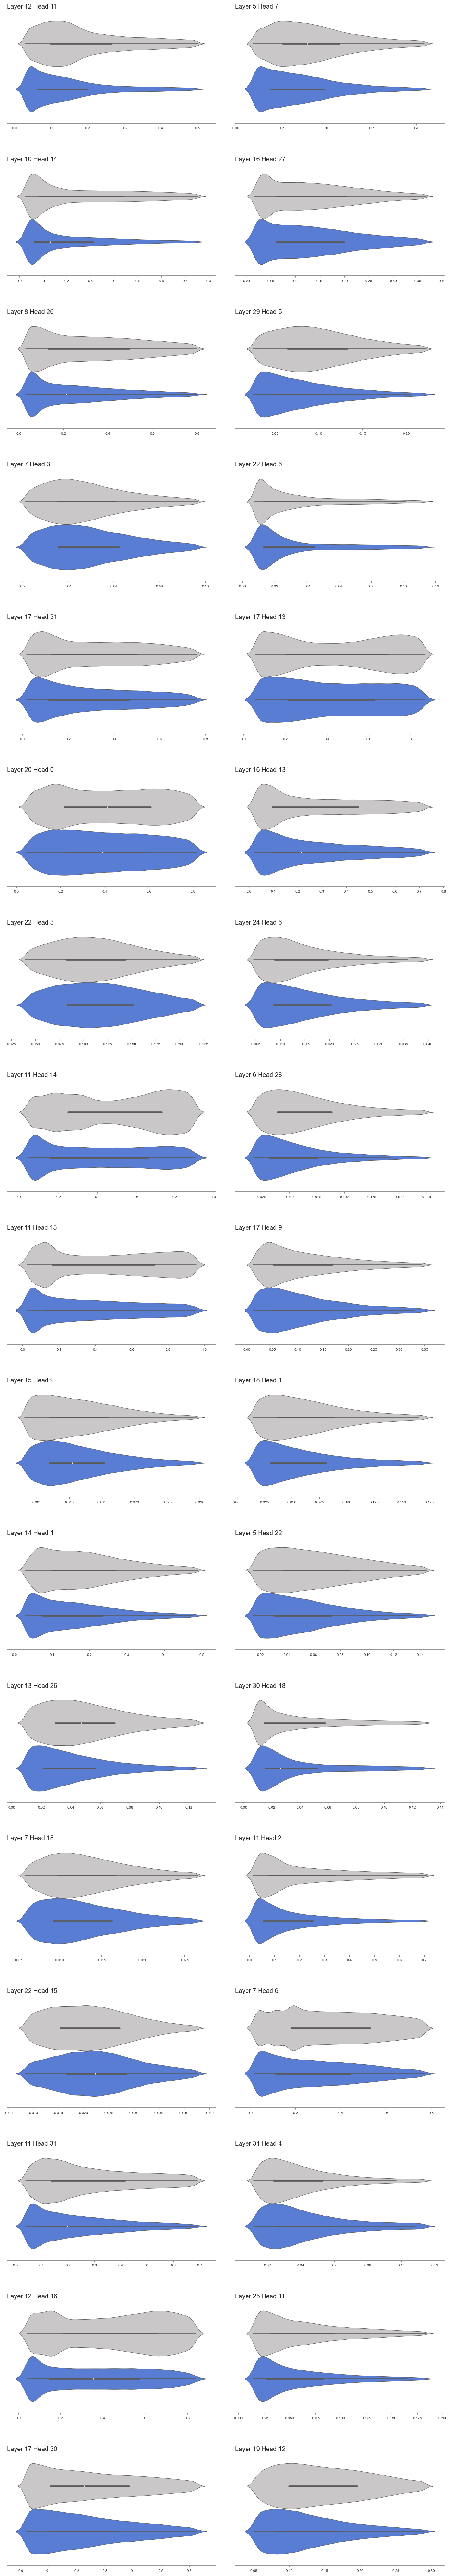

In [33]:
viz_numeric_data(
    context_df[list(common_features) + ['label', 'dataset']],
    list(common_features),
    'label',
    group_column=None,
    fig_cols=2,
    orient='h',
    title_func=lambda x: " ".join(x.split('_')).title(),
    show_stripplot=False
)

### Grouped by dataset

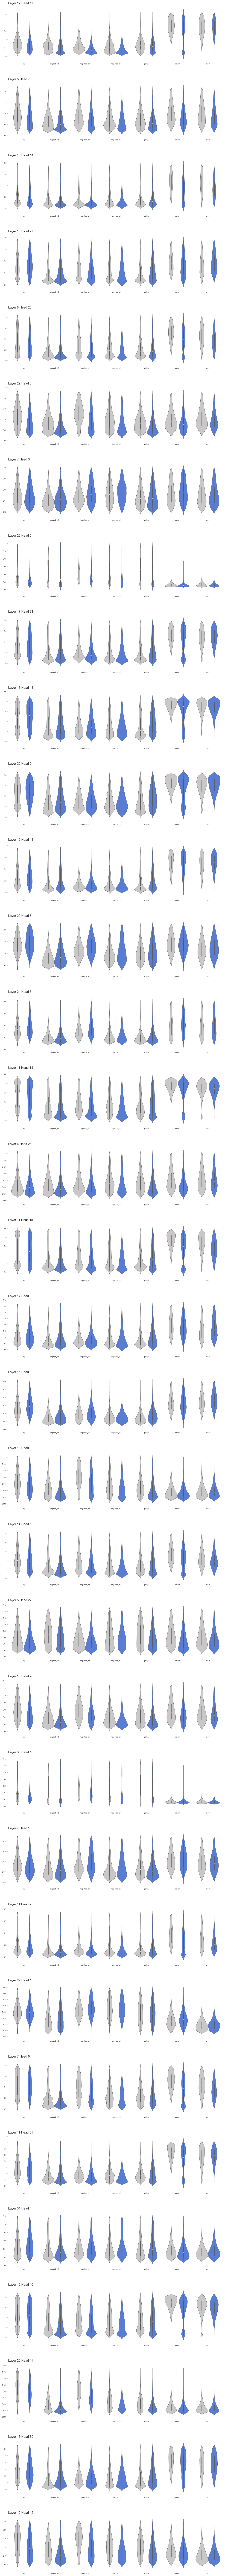

In [34]:
viz_numeric_data(
    context_df[list(common_features) + ['label', 'dataset']],
    list(common_features),
    'label',
    group_column='dataset',
    fig_cols=1,
    orient='v',
    title_func=lambda x: " ".join(x.split('_')).title(),
    title_pad=10,
    show_stripplot=False
)

In [18]:
from golemai.dataset.custom_column_selectors import ProportionAggSelector, JensenShannonSelector
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler

In [19]:
def train_and_eval(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    model: Pipeline,
):
    
    model.fit(X_train, y_train)

    train_pred = model.predict_proba(X_train)
    auc_train = roc_auc_score(y_train, train_pred[:, 1])

    val_pred = model.predict_proba(X_val)
    auc_val = roc_auc_score(y_val, val_pred[:, 1])

    test_pred = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, test_pred[:, 1])

    if 'coef_' in dir(model.named_steps['model']):
        feature_importance = model.named_steps['model'].coef_[0]
    else:
        feature_importance = model.named_steps['model'].feature_importances_

    return {
        'train_auc': auc_train,
        'val_auc': auc_val,
        'test_auc': auc_test,
    }, feature_importance

In [28]:
def train_model(
        context_df: pd.DataFrame, 
        models: dict,
        use_cv: bool = True,
        features: list = None
    ):

    validation_results = []
    feature_importances = {}

    # Loop over each unique dataset
    for dataset in context_df['dataset'].unique():

        in_dist_sample = context_df.loc[context_df['dataset'] != dataset]
        out_dist_sample = context_df.loc[context_df['dataset'] == dataset]

        feature_importances[dataset] = []

        for model_name in models.keys():

            X_train, X_test = in_dist_sample.drop(columns=['label', 'dataset']), out_dist_sample.drop(columns=['label', 'dataset'])

            if features is not None:
                X_train, X_test = X_train[features], X_test[features]

            y_train, y_test = in_dist_sample['label'], out_dist_sample['label']

            aucs_train, aucs_val, aucs_test = [], [], []

            if use_cv:
                
                skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

                for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
                    
                    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
                    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

                    model = clone(models[model_name])

                    aucs, feature_importance = train_and_eval(X_tr, y_tr, X_val, y_val, X_test, y_test, model)
                    feature_importances[dataset].append(feature_importance)

                    aucs_train.append(aucs['train_auc'])
                    aucs_val.append(aucs['val_auc'])
                    aucs_test.append(aucs['test_auc'])

                    print(f'Fold: {i} Dataset: {dataset}, Model: {model_name}, Train AUC: {aucs["train_auc"]}, Val AUC: {aucs["val_auc"]}, Test AUC: {aucs["test_auc"]}')

            else:

                model = clone(models[model_name])

                aucs, feature_importance = train_and_eval(X_train, y_train, X_train, y_train, X_test, y_test, model)
                feature_importances[dataset].append(feature_importance)

                aucs_train.append(aucs['train_auc'])
                aucs_val.append(aucs['val_auc'])
                aucs_test.append(aucs['test_auc'])

            train_auc = np.mean(aucs_train)
            auc_val = np.mean(aucs_val)
            auc_test = np.mean(aucs_test)

            print(f'Dataset: {dataset}, Model: {model_name}, Train AUC: {train_auc}, Val AUC: {auc_val}, Test AUC: {auc_test}')

            # Store the result
            validation_results.append({
                'dataset': dataset,
                'columns_selection': model.named_steps['selector'].__class__.__name__ if 'selector' in model.named_steps else 'all',
                'model': model_name,
                'train_auc': train_auc,
                'val_auc': auc_val,
                'test_auc': auc_test
            })

    return {
        'validation_results': pd.DataFrame(validation_results),
        'feature_importances': feature_importances
    }

    print('\n\n')

In [21]:
def random_undersample(X, y):
    return RandomUnderSampler(random_state=42).fit_resample(X, y)

In [22]:
context_df = context_df.loc[context_df['dataset'].isin(['nq', 'cnndm'])]

In [23]:
log_reg_config = {
    'max_iter': 10000,
    'random_state': 42,
    'class_weight': 'balanced',
    'n_jobs': -1,
}

In [24]:
models = {
    'logistic_reg_js': Pipeline(
        [
            # ('selector', JensenShannonSelector(n_features=25)),
            # ('sampler', FunctionSampler(func=random_undersample)),
            ('scaler', RobustScaler()),
            ('model', LogisticRegression(**log_reg_config)),
        ]
    ),
}

In [25]:
context_df['random_feature'] = np.random.rand(context_df.shape[0])

C:\Users\Piotr.Matys\AppData\Local\Temp\ipykernel_18688\2755856749.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  context_df['random_feature'] = np.random.rand(context_df.shape[0])


In [26]:
context_df

layer_0_head_0  layer_0_head_1  layer_0_head_2  layer_0_head_3  \
0            0.862583        0.950571        0.955657        0.607267   
1            0.895377        0.952864        0.953881        0.597257   
2            0.894973        0.947498        0.951068        0.545653   
3            0.888586        0.943166        0.951327        0.540191   
4            0.887808        0.940872        0.951077        0.537787   
...               ...             ...             ...             ...   
40017        0.836640        0.932360        0.939603        0.530855   
40018        0.805142        0.892085        0.910527        0.328802   
40019        0.861766        0.934227        0.938367        0.530517   
40020        0.848643        0.932523        0.938219        0.525289   
40021        0.844267        0.931284        0.937499        0.520027   

       layer_0_head_4  layer_0_head_5  layer_0_head_6  layer_0_head_7  \
0            0.913443        0.955148        0.937347        0.972949   
1            0.911656        0.957951        0.928445        0.972196   
2            0.899053        0.954128        0.922510        0.966877   
3            0.896747        0.952348        0.932454        0.967140   
4            0.894441        0.953118        0.932198        0.966894   
...               ...             ...             ...             ...   
40017        0.876998        0.905972        0.917872        0.986687   
40018        0.758773        0.898408        0.856254        0.950047   
40019        0.876776        0.909383        0.917664        0.985984   
40020        0.875567        0.904045        0.921650        0.985337   
40021        0.875863        0.902278        0.924033        0.985151   

       layer_0_head_8  layer_0_head_9  ...  layer_31_head_25  \
0            0.880384        0.970915  ...          0.220478   
1            0.916744        0.970670  ...          0.231602   
2            0.911801        0.959227  ...          0.212779   
3            0.904399        0.957959  ...          0.181849   
4            0.901584        0.958730  ...          0.228968   
...               ...             ...  ...               ...   
40017        0.876480        0.935982  ...          0.254950   
40018        0.820950        0.899462  ...          0.064483   
40019        0.914041        0.934227  ...          0.174553   
40020        0.896796        0.933041  ...          0.178505   
40021        0.892955        0.933356  ...          0.173386   

       layer_31_head_26  layer_31_head_27  layer_31_head_28  layer_31_head_29  \
0              0.212467          0.067389          0.477828          0.124607   
1              0.216213          0.075484          0.468292          0.124259   
2              0.130549          0.085864          0.423518          0.162803   
3              0.158512          0.076642          0.411392          0.174580   
4              0.172969          0.060814          0.452578          0.191848   
...                 ...               ...               ...               ...   
40017          0.166992          0.050932          0.451175          0.113441   
40018          0.033921          0.022279          0.165191          0.091092   
40019          0.162907          0.051272          0.455985          0.111926   
40020          0.161418          0.040452          0.447621          0.109058   
40021          0.166134          0.043249          0.434565          0.116152   

       layer_31_head_30  layer_31_head_31  label  dataset  random_feature  
0              0.225436          0.037159      0       nq        0.924184  
1              0.246992          0.041526      0       nq        0.643159  
2              0.323822          0.047840      0       nq        0.991835  
3              0.344314          0.045398      0       nq        0.629255  
4              0.428597          0.054563      0       nq        0.839847  
...                 ...               ...    ...      .

In [27]:
results = train_model(
    context_df=context_df,
    models=models,
    features=None,
    use_cv=True
)

Dataset: nq, Model: logistic_reg_js, Train AUC: 0.968565306883024, Val AUC: 0.9492642823981461, Test AUC: 0.6460716307901573
Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.8965011288055613, Val AUC: 0.8806071963590203, Test AUC: 0.6549654062596847


In [29]:
feature_importances = results['feature_importances']

In [30]:
train_cols = context_df.drop(columns=['label', 'dataset']).columns

nq_f_im = np.stack(feature_importances['nq'])
cnndm_f_im = np.stack(feature_importances['cnndm'])

nq_f_im = np.mean(nq_f_im, axis=0)
cnndm_f_im = np.mean(cnndm_f_im, axis=0)

nq_f_im_df = pd.DataFrame(nq_f_im, index=train_cols, columns=['nq'])
cnndm_f_im_df = pd.DataFrame(cnndm_f_im, index=train_cols, columns=['cnndm'])

nq_th = np.abs(nq_f_im_df.loc['random_feature', 'nq'])
cnndm_th = np.abs(cnndm_f_im_df.loc['random_feature', 'cnndm'])

nq_f_im_df = nq_f_im_df.loc[np.abs(nq_f_im_df['nq']) > nq_th]
cnndm_f_im_df = cnndm_f_im_df.loc[np.abs(cnndm_f_im_df['cnndm']) > cnndm_th]

nq_f_im_df = nq_f_im_df.sort_values('nq', ascending=False)
cnndm_f_im_df = cnndm_f_im_df.sort_values('cnndm', ascending=False)

above_randomness_features = set(nq_f_im_df.index.to_list()) & set(cnndm_f_im_df.index.to_list())

In [35]:
log_reg_config = {
    'max_iter': 10000,
    'random_state': 42,
    'class_weight': 'balanced',
    'n_jobs': -1,
    'C': 0.1
}

models = {
    'logistic_reg_js': Pipeline(
        [
            ('selector', JensenShannonSelector(n_features=200)),
            # ('sampler', FunctionSampler(func=random_undersample)),
            ('scaler', RobustScaler()),
            ('model', LogisticRegression(**log_reg_config)),
        ]
    ),
}

results = train_model(
    context_df=context_df,
    models=models,
    features=list(above_randomness_features),
    use_cv=True
)

Fold: 0 Dataset: nq, Model: logistic_reg_js, Train AUC: 0.8511827456742456, Val AUC: 0.8318256700654829, Test AUC: 0.6456171616114861
Fold: 1 Dataset: nq, Model: logistic_reg_js, Train AUC: 0.8439982985370424, Val AUC: 0.8360286586789785, Test AUC: 0.651479162616384
Dataset: nq, Model: logistic_reg_js, Train AUC: 0.847590522105644, Val AUC: 0.8339271643722307, Test AUC: 0.6485481621139351
Fold: 0 Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.7843326174039241, Val AUC: 0.7844931474903821, Test AUC: 0.6729292748662923
Fold: 1 Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.790079522379883, Val AUC: 0.7806303735774385, Test AUC: 0.6913710409716125
Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.7872060698919036, Val AUC: 0.7825617605339104, Test AUC: 0.6821501579189524


In [37]:
log_reg_config = {
    'max_iter': 10000,
    'random_state': 42,
    'class_weight': 'balanced',
    'n_jobs': -1,
    'solver': 'saga',
    'penalty': 'l2',
    'C': 1
}

models = {
    'logistic_reg_js': Pipeline(
        [
            # ('selector', JensenShannonSelector(n_features=25)),
            # ('sampler', FunctionSampler(func=random_undersample)),
            ('scaler', RobustScaler()),
            ('model', LogisticRegression(**log_reg_config)),
        ]
    ),
}

In [ ]:
results = train_model(
    context_df=context_df,
    models=models,
    features=list(above_randomness_features),
    use_cv=False
)

In [118]:
nq_f_im = np.stack(feature_importances['nq'])
cnndm_f_im = np.stack(feature_importances['cnndm'])

nq_f_im = np.mean(nq_f_im, axis=0)
cnndm_f_im = np.mean(cnndm_f_im, axis=0)

nq_f_im_df = pd.DataFrame(nq_f_im, index=list(above_randomness_features), columns=['nq'])
cnndm_f_im_df = pd.DataFrame(cnndm_f_im, index=list(above_randomness_features), columns=['cnndm'])

nq_f_im_df = nq_f_im_df[np.abs(nq_f_im_df['nq']) >= 0.02]
cnndm_f_im_df = cnndm_f_im_df[cnndm_f_im_df['cnndm'] >= 0.02]

after_sec_filter = set(nq_f_im_df.index.to_list()) & set(cnndm_f_im_df.index.to_list())

In [181]:
N_FEATURES = 5

In [190]:
log_reg_config = {
    'max_iter': 10000,
    'random_state': 42,
    'class_weight': 'balanced',
    'n_jobs': -1,
    'solver': 'saga',
    'penalty': None
}

lgbm_config = {
    'n_estimators': 250,
    'learning_rate': 0.001,
    'max_depth': 10,
    'num_leaves': 15,
    'random_state': 42,
    'n_jobs': -1,
    'silent': True,
    'verbose': -1,
    'class_weight': 'balanced'
}

models = {
    'logistic_reg_js': Pipeline(
        [
            ('selector', JensenShannonSelector(n_features=N_FEATURES)),
            # ('sampler', FunctionSampler(func=random_undersample)),
            ('scaler', RobustScaler()),
            ('model', LogisticRegression(**log_reg_config)),
        ]
    ),
}

In [184]:
res = train_model(
    context_df=context_df,
    models=models,
    features=list(after_sec_filter)
)

Dataset: nq, Model: logistic_reg_js, Train AUC: 0.7392819162151598, Val AUC: 0.7277230364965053, Test AUC: 0.5009861710714885

Dataset: nq, Model: logistic_reg_js, Train AUC: 0.7314776031178991, Val AUC: 0.744619600635356, Test AUC: 0.5868057919786902

Dataset: nq, Model: logistic_reg_js, Train AUC: 0.7353797596665295, Val AUC: 0.7361713185659307, Test AUC: 0.5438959815250893
Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.6779892636502367, Val AUC: 0.6819429506219994, Test AUC: 0.67499825963021

Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.6833087977575582, Val AUC: 0.6773445477303291, Test AUC: 0.6798860014308823

Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.6806490307038975, Val AUC: 0.6796437491761642, Test AUC: 0.6774421305305461


In [185]:
res['validation_results']

dataset      columns_selection            model  train_auc   val_auc  \
0      nq  JensenShannonSelector  logistic_reg_js   0.735380  0.736171   
1   cnndm  JensenShannonSelector  logistic_reg_js   0.680649  0.679644   

   test_auc  
0  0.543896  
1  0.677442

### It is possible to train a model on `5` features and achieve a better performacne than on all features for `nq` -> `cnndm` dataset. However, the performance on `cnndm` -> `nq` dataset is much worse. For fist fold is random

In [188]:
N_FEATURES = 250

models = {
    'logistic_reg_js': Pipeline(
        [
            ('selector', ProportionAggSelector(n_features=N_FEATURES)),
            # ('sampler', FunctionSampler(func=random_undersample)),
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(**log_reg_config)),
        ]
    ),
}

res = train_model(
    context_df=context_df,
    models=models,
    features=list(after_sec_filter)
)

Dataset: nq, Model: logistic_reg_js, Train AUC: 0.895635696271276, Val AUC: 0.8781402325294562, Test AUC: 0.6591268150674006

Dataset: nq, Model: logistic_reg_js, Train AUC: 0.8926729073756088, Val AUC: 0.882996038034515, Test AUC: 0.6607932872742314

Dataset: nq, Model: logistic_reg_js, Train AUC: 0.8941543018234424, Val AUC: 0.8805681352819856, Test AUC: 0.6599600511708159
Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.795135551656357, Val AUC: 0.7871823934262917, Test AUC: 0.6699162173061397

Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.7951285584431538, Val AUC: 0.7870955590380773, Test AUC: 0.6627963421466072

Dataset: cnndm, Model: logistic_reg_js, Train AUC: 0.7951320550497554, Val AUC: 0.7871389762321845, Test AUC: 0.6663562797263735


In [189]:
res['validation_results']

dataset      columns_selection            model  train_auc   val_auc  \
0      nq  ProportionAggSelector  logistic_reg_js   0.894154  0.880568   
1   cnndm  ProportionAggSelector  logistic_reg_js   0.795132  0.787139   

   test_auc  
0  0.659960  
1  0.666356

### On `250` features it is possible to match paper performance (or even exceed it, because of inproperly validated test set in LL)

In [196]:
lgbm_config = {
    'n_estimators': 500,
    'learning_rate': 0.0005,
    'max_depth': 10,
    'num_leaves': 15,
    'random_state': 42,
    'n_jobs': -1,
    'silent': True,
    'verbose': -1,
    'class_weight': 'balanced'
}

models = {
    'lgbm_all_no_sampler': Pipeline(
        [
            ('model', LGBMClassifier(
                **lgbm_config
            )),
        ]
    ),
}

res = train_model(
    context_df=context_df,
    models=models,
    features=list(after_sec_filter)
)

Dataset: nq, Model: lgbm_all_no_sampler, Train AUC: 0.8359108496790965, Val AUC: 0.7903515741211375, Test AUC: 0.5895834508941947

Dataset: nq, Model: lgbm_all_no_sampler, Train AUC: 0.8247507784369899, Val AUC: 0.8080718998018563, Test AUC: 0.5847259566955414

Dataset: nq, Model: lgbm_all_no_sampler, Train AUC: 0.8303308140580432, Val AUC: 0.7992117369614969, Test AUC: 0.5871547037948681
Dataset: cnndm, Model: lgbm_all_no_sampler, Train AUC: 0.7485059315678595, Val AUC: 0.7399587211455776, Test AUC: 0.6940646978060581

Dataset: cnndm, Model: lgbm_all_no_sampler, Train AUC: 0.7478055080578498, Val AUC: 0.7321240544599947, Test AUC: 0.7113845962702108

Dataset: cnndm, Model: lgbm_all_no_sampler, Train AUC: 0.7481557198128547, Val AUC: 0.7360413878027862, Test AUC: 0.7027246470381344


In [197]:
res['validation_results']

dataset columns_selection                model  train_auc   val_auc  \
0      nq               all  lgbm_all_no_sampler   0.830331  0.799212   
1   cnndm               all  lgbm_all_no_sampler   0.748156  0.736041   

   test_auc  
0  0.587155  
1  0.702725

### On `nq` -> `cnndm` 0.7 AUC can be exceeded using `LGBM`, but it performes poorly on `cnndm` -> `nq` dataset. And it can be seen that the model overfits only a little bit, which means a decent generalization.